In [77]:
import distutils.util as distutils
import os
import mujoco
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer
        elif name == 'xml':
            del xml
        elif name == 'model':
            del model
        elif name == 'data':
            del data

In [79]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

In [80]:
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

In [81]:
data = mujoco.MjData(model)
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


In [82]:
mujoco.mj_kinematics(model,data)
print('\nnamed access:\n', data.geom('green_sphere').xpos)


named access:
 [0.2 0.2 0.2]


""

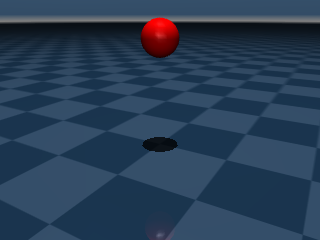

In [84]:
del xml, model, data, renderer
with open('./model/Adding-World-Bodies-Bounce/adding_world_bodies.xml', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

Let us explore joints in mujoco now. We will try to explore all joint types mentioned in the slides from the previous session using primitive joints in mujoco.


### The Revolute Joint

""

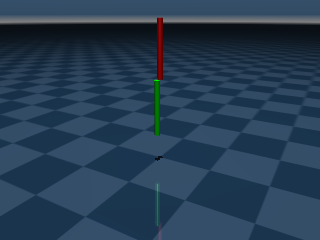

In [95]:
del xml, model, data, renderer
with open('./model/Joints/planar_double_pendulum.xml', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [96]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)


# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.qpos[0] = 2
data.qpos[1] = 1
#set joint axis view flag to true
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

### The Universal Joint

universal joint is 2 orthogonally intersecting(stacked) revolute joints

""

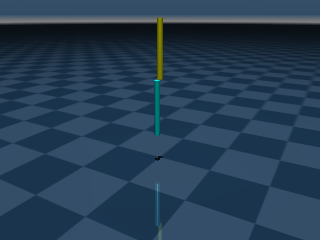

In [93]:
del xml, model, data, renderer
with open('./model/Joints/spatial_double_pendulum.xml', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [94]:
duration = 5.8  # (seconds)
framerate = 60  # (Hz)


# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.qpos[0] = 1
data.qpos[1] = 2
#set joint axis view flag to true
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

mj_step() = mj_forward() + bound checking + simulation state advancement


the $\texttt{mj\_step\(\)}$ function is the core of the MuJoCo simulator.

It takes in the current state of the environment and the action to be taken, and returns the next state

In [20]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

As you can see above the ball did not bounce in the last session's example but in today's example it does. This is because we have set the property solref
in the mjcf file. 

Now is a good time to talk about constraint solver in MuJoCo. 

In [21]:
[model.geom(i).name for i in range(model.ngeom)]

['floor', 'body']

solref can be used to set the reference acceleration in the constraint space, where 

$$ m\ddot{x} + \tilde{b}\dot{x} + \tilde{k}x = \tilde{Q}$$

where $\tilde{Q}$ is the constraint violation force

so, 

$$\ddot{x} = \frac{1}{m}(\tilde{Q} - \tilde{b}\dot{x} - \tilde{k}x)$$

let the force violation be negligibly small, then :

$$\ddot{x} = - \frac{\tilde{b}}{m}\dot{x} - \frac{\tilde{k}x}{m}$$

$$\ddot{x} = -b(v) - kx$$

let, $a^{*} = -b(v)-kx$

here $b$ is damping and $k$ is stiffness and $a^{*}$ is the reference acceleration in the constraint space.
 

In [25]:
for i in range(model.ngeom):
    print(model.geom(i).solref) 


[1.  0.1]
[0.0001 0.001 ]


In [60]:
model.geom(0).solref = [-1000, -0]
model.geom(1).solref = [-1000, -0]

You can notice that [-1000, 0] for solref value means that it is a perfectly elastic collision(cooresponding to the zero damping value) and of stiffness 1000 at the point of contact.

In the original MJCF of this example you can see the values set in "timeconstant dampratio" format

In [61]:
del renderer
renderer = mujoco.Renderer(model)

frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

In [10]:
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos) #position and orientation in quaternions
print('Generalized velocities:', data.qvel) #velocity

Total number of DoFs in the model: 6
Generalized positions: [0.         0.         0.46976484 1.         0.         0.
 0.        ]
Generalized velocities: [0.         0.         0.89674455 0.         0.         0.        ]


""

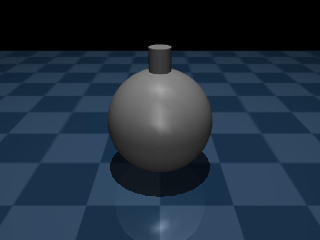

In [11]:
del xml, model, data, renderer
with open('./model/ContypeConaffinity/tippietop.xml', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="closeup")
media.show_image(renderer.render())

In [12]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, "closeup")
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)